In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv'))
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,iceplant
0,134,125,103,170,0.118421,2012,5,126,1
1,130,114,101,164,0.115646,2012,5,126,1
2,132,110,98,160,0.095890,2012,5,126,1


In [3]:
df_encoded = pd.get_dummies(df,columns=['year'])
df_encoded

,r,g,b,nir,ndvi,month,day_in_year,iceplant,year_2012,year_2014,year_2018,year_2020
0,134,125,103,170,0.118421,5,126,1,1,0,0,0
1,130,114,101,164,0.115646,5,126,1,1,0,0,0
2,132,110,98,160,0.095890,5,126,1,1,0,0,0
3,136,122,106,148,0.042254,5,126,1,1,0,0,0
4,137,115,108,139,0.007246,5,126,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
344423,52,72,52,134,0.440860,6,159,0,0,0,0,1
344424,64,78,52,153,0.410138,6,159,0,0,0,0,1
344425,60,82,54,161,0.457014,6,159,0,0,0,0,1
344426,55,73,49,154,0.473684,6,159,0,0,0,0,1


In [4]:
X_train, X_test, y_train, y_test = mpe.test_train_from_df(df_encoded)
mpe.test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     1.9 :1
          counts  percentage
iceplant                    
0         159093       65.99
1          82006       34.01

TEST SET COUNTS:
no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          68381       66.18
1          34948       33.82



In [5]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
predictions = rfc.predict(X_test)
mpe.print_threshold_metrics(y_test, predictions)


true negatives: 67094     false positives: 1287
false negatives: 1216     true positives: 33732

sensitivity (TP/P): 96.52 %
specificity (TN/N): 98.12 %
G-mean:  0.97

precision (TP/(TP+FP)): 96.32 %

MCC:  0.9459157601425896

F1-measure:  0.96423
F0.5-measure (min false positives):  0.96364
F2-measure (min false negatives)  :  0.96481

accuracy: 97.58 %



In [7]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [10]:
forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'month', 'day_in_year', 'year_2012', 'year_2014','year_2018', 'year_2020' ])
forest_importances

r              0.233157
g              0.089580
b              0.123849
nir            0.123359
ndvi           0.053569
month          0.008804
day_in_year    0.030558
year_2012      0.002291
year_2014      0.014710
year_2018      0.000611
year_2020      0.023085
dtype: float64

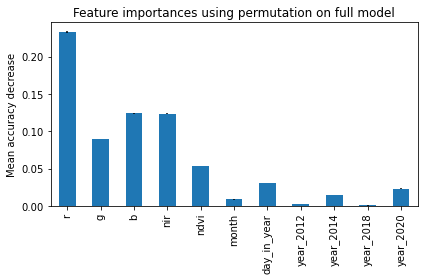

In [11]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Predictions over aois

In [44]:
def add_onehot_years(veg, year):
    year_labels = ['year_2012','year_2014','year_2018','year_2020']
    d = {'label': year_labels}
    years = [2012, 2014, 2018, 2020]
    df = pd.DataFrame(data = d, index = years)
    
    # to later reorder columns to match RF features order
    cols = list(veg) + year_labels
    
    one_column = df.loc[year].label
    veg[one_column] = 1
    
    zero_columns = df[df.index!= year].label.to_list()
    for i in range(0,len(zero_columns)):
        veg[zero_columns[i]] = 0
    veg = veg[cols]
    return veg

In [42]:
def features_over_aoi(item, image):

    veg = ipf.select_ndvi_df(image)
    
    veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))
    veg['month'] = item.datetime.month
    veg['day_in_year'] = ipf.day_in_year(item.datetime.day, item.datetime.month, item.datetime.year)
    
    veg = veg[['r','g','b','nir','ndvi','month','day_in_year']] # order features
    
    veg = add_onehot_years(veg, item.datetime.year)
    return veg

# -----------------------------------------------

def predict_df(veg,rfc):

    index = veg.index
    features = np.array(veg)

    predictions_class = rfc.predict(features)
    c = {'prediction': predictions_class}
    predictions_df = pd.DataFrame(c, index = index)
    
    return predictions_df


def predict_over_aoi(itemid, aoi, rfc):
    image = ipf.open_window_in_scene(itemid, aoi)
    item = ipf.get_item_from_id(itemid)    

    veg = features_over_aoi(item, image)
    df = predict_df(veg, rfc)
    
    nrows = image.shape[1]
    ncols = image.shape[2]
    index = df[df.prediction == 1].index.to_numpy()
    
    return ipf.indices_backto_image(nrows, ncols, index)



In [14]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
lagoon = aois.iloc[4]
lagoon

name                                              campus point
region                                                  goleta
itemid_12               ca_m_3411934_sw_11_1_20120505_20120730
itemid_14               ca_m_3411934_sw_11_1_20140601_20141030
itemid_16              ca_m_3411934_sw_11_.6_20160713_20161004
itemid_18             ca_m_3411934_sw_11_060_20180722_20190209
itemid_20                      ca_m_3411934_sw_11_060_20200521
geometry     POLYGON ((-119.8534713523 34.4028697719, -119....
Name: 4, dtype: object

In [41]:
image = ipf.open_window_in_scene(lagoon.itemid_14, lagoon.geometry)
item = ipf.get_item_from_id(lagoon.itemid_14)    

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    veg = features_over_aoi(item, image)
    veg

['r', 'g', 'b', 'nir', 'ndvi', 'month', 'day_in_year', 'year_2014', 'year_2012', 'year_2018', 'year_2020', ['year_2012', 'year_2014', 'year_2018', 'year_2020']]


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    preds = predict_over_aoi(conc.itemid_20, conc.geometry, rfc)
    plot_preds_vs_original(preds20, conc.itemid_20, conc.geometry, 2020)